In [1]:
from args_experiments import *
from models import *
from load_data import *
from training import *
from utils import *

import random
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
args = args_springs()
args_encoder = args_seq2graph()

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

train_loader, valid_loader, test_loader = load_springs_data(path=args.path,
                                                            batch_size=args.batch_size,
                                                            dataset_name=args.suffix,
                                                            shuffle=True)

args.num_atoms, args.time_steps, args.in_dim = train_loader.dataset[0][0].shape
args.first_hidden = 1

/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/non_stationary/avec_overlap/multiple_trajectories/ _springs10


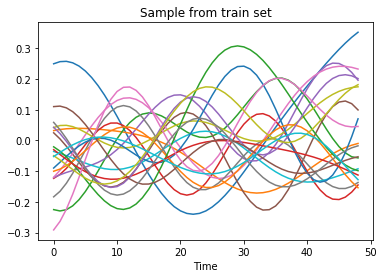

In [4]:
plt.plot(train_loader.dataset[0][0].transpose(1, 2).reshape(20, 49).numpy().T);
plt.xlabel('Time')
plt.title('Sample from train set');

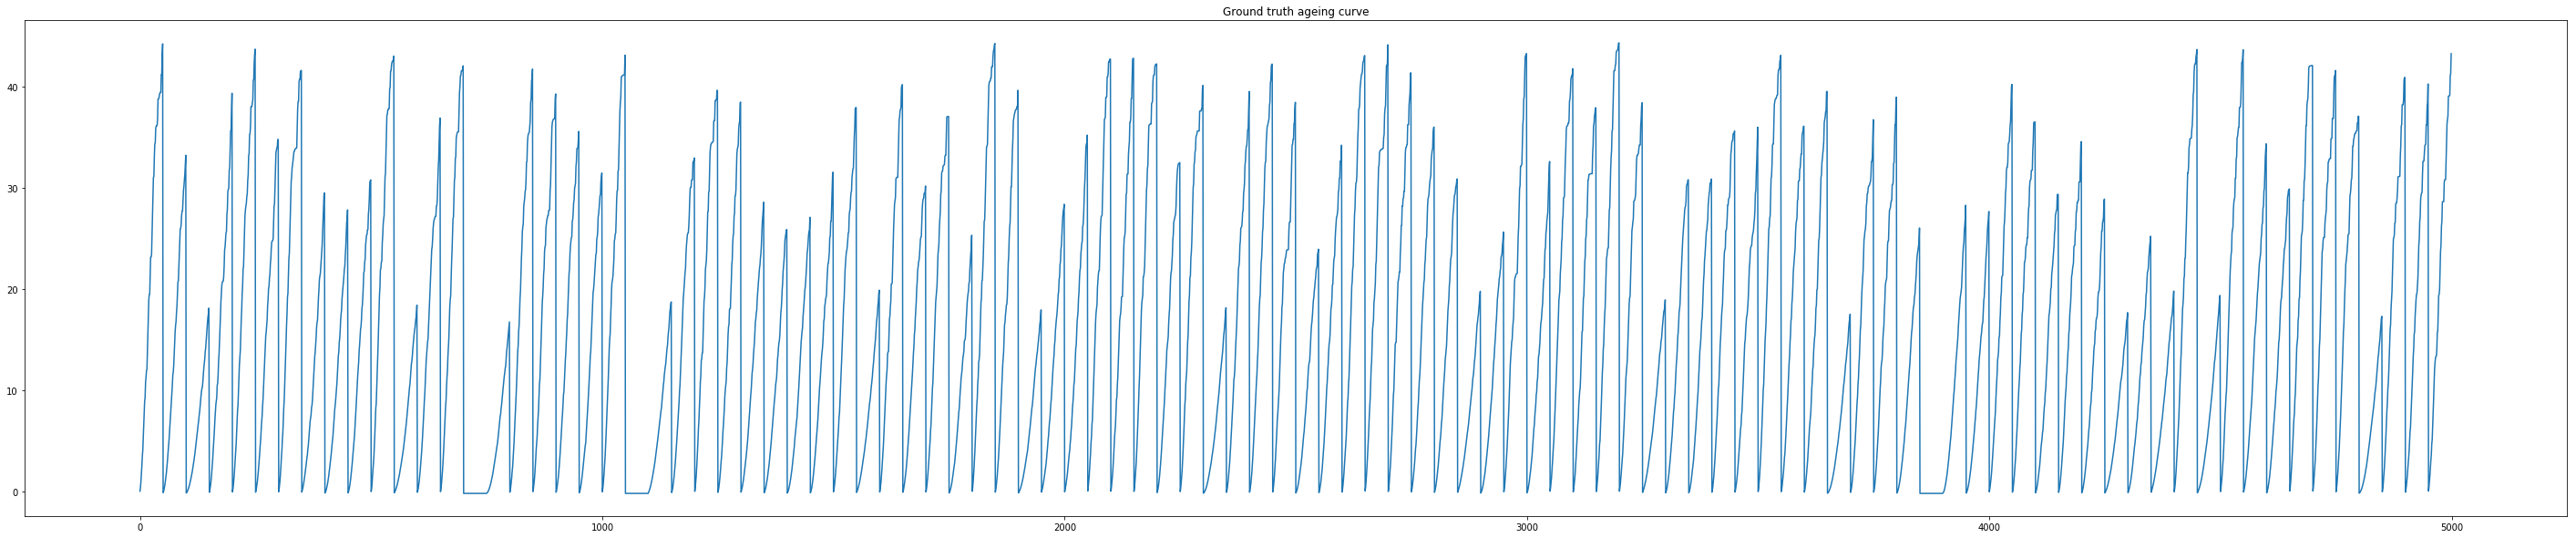

In [5]:
plt.figure(figsize=(50, 10))
plt.plot([((train_loader.dataset[0][2]-d[2]).numpy()).sum() for d in train_loader.dataset]);
plt.title('Ground truth ageing curve');

### GL-VAR model

In [6]:
g = GC(G_i, args.num_atoms, args.hidden_GC, 1, lag=args.lag, activation=nn.ReLU()).to(args.device)

/home/epineau/anaconda3/envs/edouard/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [7]:
g.load_state_dict(torch.load(os.getcwd() + '/weights_springs10/g_sparse' + args.suffix + '.pt'))
W_prior = torch.stack([m.layers[0].weight.squeeze(-1) for m in g.model_list])
adjacency = (W_prior.sum(-1).sum(1) != 0).float().unsqueeze(1).unsqueeze(-1)

if g.bias:
    bias_prior = torch.stack([m.layers[0].bias.data for m in g.model_list]).unsqueeze(0).unsqueeze(-1)
else:
    bias_prior = torch.zeros([1, args.num_atoms, g.model_list[0].layers[0].weight.shape[0], 1])

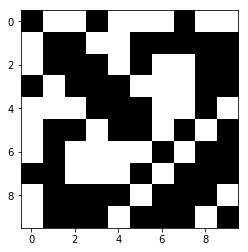

In [8]:
plt.imshow(adjacency.squeeze().cpu().detach().numpy(), cmap='binary');

##### This graph has been obtained with the notebook 'graph_inference_cmapss_001.ipynb'. 

### Inference function $F_\theta$

In [9]:
f_theta = RelationalEncoder(args.time_steps*args.in_dim, 
                                    args_encoder.encoder_hidden, 
                                    args.lag)
f_theta.P_prior = nn.Parameter(torch.zeros_like(W_prior))

f_theta = f_theta.to(args.device)

off_diag = np.ones([args.num_atoms, args.num_atoms])

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).to(args.device)
rel_send = torch.FloatTensor(rel_send).to(args.device)

optimizer_encoder = optim.Adam(f_theta.parameters(), lr=args_encoder.lr)
scheduler_encoder = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=100, gamma=0.9)

### Training with regularization

In [10]:
eta = 1e-5

for epoch in range(1000):
    train_seq2graph_epoch(epoch, f_theta, g, train_loader, optimizer_encoder, scheduler_encoder, 
                          eta, rel_rec, rel_send, args)

Epoch: 0000 loss: 48.56134 reg: 650.46388
Epoch: 0025 loss: 1.12943 reg: 618.10911
Epoch: 0050 loss: 0.79715 reg: 537.17953
Epoch: 0075 loss: 0.39587 reg: 383.72755
Epoch: 0100 loss: 0.09616 reg: 189.09612
Epoch: 0125 loss: 0.00965 reg: 51.10534
Epoch: 0150 loss: 0.00292 reg: 9.22622
Epoch: 0175 loss: 0.00225 reg: 3.96097
Epoch: 0200 loss: 0.00182 reg: 2.57610
Epoch: 0225 loss: 0.00153 reg: 2.32771
Epoch: 0250 loss: 0.00125 reg: 2.12616
Epoch: 0275 loss: 0.00102 reg: 1.93471
Epoch: 0300 loss: 0.00090 reg: 1.87061
Epoch: 0325 loss: 0.00080 reg: 1.91168
Epoch: 0350 loss: 0.00074 reg: 1.95620
Epoch: 0375 loss: 0.00070 reg: 1.99111
Epoch: 0400 loss: 0.00067 reg: 2.00892
Epoch: 0425 loss: 0.00063 reg: 2.01972
Epoch: 0450 loss: 0.00060 reg: 2.05444
Epoch: 0475 loss: 0.00059 reg: 2.03818
Epoch: 0500 loss: 0.00057 reg: 2.06592
Epoch: 0525 loss: 0.00056 reg: 2.08421
Epoch: 0550 loss: 0.00054 reg: 2.08794
Epoch: 0575 loss: 0.00054 reg: 2.10404
Epoch: 0600 loss: 0.00051 reg: 2.09877
Epoch: 0625 l

In [25]:
torch.save(f_theta.state_dict(), os.getcwd() + '/weights' + args.suffix + '/seq2graph' + args.suffix + '.pt')

### Faire des dessins

Ageing curve estimation

In [12]:
g.load_state_dict(torch.load(os.getcwd() + '/weights' + args.suffix + '/g_sparse' + args.suffix + '.pt'))
f_theta.load_state_dict(torch.load(os.getcwd() + '/weights' + args.suffix + '/seq2graph' + args.suffix + '.pt'))

g = g.eval()
w_theta = w_theta.eval()

In [13]:
W_prior = []
for i in range(args.num_atoms):
    weight = g.model_list[i].layers[0].weight.detach().squeeze(-1)
    W_prior.append(weight)

W_prior = torch.cat(W_prior)
adjacency = (W_prior.sum(-1) != 0).float().unsqueeze(0).unsqueeze(-1)

In [14]:
W_valid = []
for batch_idx, (data, label, individual) in enumerate(valid_loader):
    optimizer_encoder.zero_grad()
    if args.cuda:
        data = data.cuda()

    W = f_theta(data, rel_rec, rel_send)
    W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag)
    W_sparse = W.mul(adjacency)
    W_valid.append(W_sparse.cpu().detach().numpy())
    
W_valid = np.concatenate(W_valid)
W_valid = W_valid.sum(-1)

In [15]:
W_test = []
for batch_idx, (data, label, individual) in enumerate(test_loader):
    optimizer_encoder.zero_grad()
    if args.cuda:
        data = data.cuda()

    W = f_theta(data, rel_rec, rel_send)
    W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag)
    W_sparse = W.mul(adjacency)
    W_test.append(W_sparse.cpu().detach().numpy())
    
W_test = np.concatenate(W_test)
W_test = W_test.sum(-1)

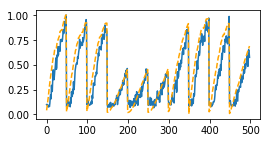

In [16]:
W_ref = W_valid[0]

ageing_curve_valid = np.array([np.sqrt(((W_ref - w)**2).sum()) for w in W_valid])
M_valid = ageing_curve_valid.max()
m_valid = ageing_curve_valid.min()

ageing_curve_test = np.array([np.sqrt(((W_ref - w)**2).sum()) for w in W_test])
ageing_curve_test = np.array([(np.sqrt(((W_ref - w)**2).sum())-m_valid)/(M_valid-m_valid) for w in W_test])

gt = np.array([np.sqrt(((test_loader.dataset[0][2] - w[2])**2).sum()).item() for w in test_loader.dataset])
M_gt = gt.max()
m_gt = gt.min()
gt = np.array([np.sqrt(((test_loader.dataset[0][2] - w[2])**2).sum() - m_gt)/(M_gt - m_gt).item() for w in test_loader.dataset])

plt.figure(figsize=(4, 2))
plt.plot(ageing_curve_test[1:500])
plt.plot(gt[1:500], c='orange', linestyle='dashed')

##### Ageing score

In [17]:
np.corrcoef(ageing_curve_test, gt)

array([[1.        , 0.95274544],
       [0.95274544, 1.        ]])

##### $\alpha$-score

In [18]:
def mean_ageing(W, i):
    return np.mean([(torch.norm(W[j], dim=-1) / (torch.norm(W[j-1], dim=-1) + 1e-10)).sum().item()
                    for j in range(i-49, i)])

In [19]:
W_test = []
for batch_idx, (data, label, individual) in enumerate(test_loader):
    optimizer_encoder.zero_grad()
    if args.cuda:
        data = data.cuda()

    W = f_theta(data, rel_rec, rel_send)
    W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag)
    W_sparse = W.mul(adjacency)
    W_test.append(W_sparse.cpu().detach().numpy())
    
W_test = np.concatenate(W_test)

In [20]:
W_estimated = W_test + W_prior.unsqueeze(0)

In [21]:
X = np.array([mean_ageing(W_estimated, i) for i in range(50, 5050, 50)])
X_seq2graph = (X - np.min(X)) / (np.max(X) - np.min(X))
y = np.array([test_loader.dataset[i][1].item() for i in range(0, 5000, 50)])
y = (y - np.min(y)) / (np.max(y) - np.min(y))

In [24]:
import scipy as sp

sp.stats.wasserstein_distance(X_seq2graph, y)

0.08934467026409429

In [23]:
np.corrcoef(y, X_seq2graph)

array([[ 1.       , -0.8691186],
       [-0.8691186,  1.       ]])